In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-test-graphs-5-3/test_graphs.bin
/kaggle/input/train-test-graphs-5-3/train_graphs.bin


In [2]:
!pip install dgl-cu110 -f https://data.dgl.ai/wheels/repo.html
!pip install torch

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 221.0 MB 22 kB/s              


In [3]:
from dgl.data.utils import load_graphs

train_graphs, train_graph_labels_dict = load_graphs('../input/train-test-graphs-5-3/train_graphs.bin')
train_graph_labels = train_graph_labels_dict['labels']
test_graphs, test_graph_labels_dict = load_graphs('../input/train-test-graphs-5-3/test_graphs.bin')
test_graph_labels = test_graph_labels_dict['labels']

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


In [4]:
print('训练样本数： ', len(train_graphs))
print('测试样本数： ', len(test_graphs))

训练样本数：  66236
测试样本数：  16561


In [5]:
import torch

# get the name of GPU
device = torch.device("cuda")

# train_data for cuda
gpu_train_g = []
for g in train_graphs:
    gpu_train_g.append(g.to(device))

gpu_train_l = train_graph_labels.to(device)

# test_data for cuda
gpu_test_g = []
for g in test_graphs:
    gpu_test_g.append(g.to(device))

gpu_test_l = test_graph_labels.to(device)

In [6]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

N = 20
t = 10
k = 10  # the number of rows for the output tensor (k = 10, 20)
T = 5
overlap = 3 # note: overlap depends on T

apps = ['diijam', 'baomoi', 'fptplay', 'iQIYI', 'bigo', 'myradio', 'spotify', 'nhaccuatui', 'soundcloud', 'sachnoiapp', 
        'phim247', 'popskid', 'truyenaudiosachnoiviet', 'vieon', 'voizfm', 'tunefm', 'wetv', 'zingmp3', 'truyenaudio', 'baohay24h',
        'freefire', 'among_us', 'azar', 'comico', 'nimotv', 'mangatoon', 'medoctruyen', 'nhacvang', 'noveltoon', 'radiofm',
        'vtvgo', 'tivi24h', 'tinder', 'tinmoi24h', 'tivi360', 'tiktok', 'linkedin', 'tiki', 'tinhte', 'lotus', 'tivi247',
        'tivi_truyentranh_webtoon', 'tuoitre_online', 'vietnamworks', 'wallstreet_journal', 'cnn_news', 'bbc_news', 'twitter', 
        'weeboo', 'twitch', 'vnexpress', 'topcv', 'toc_chien', 'wesing', 'hago', 'google_meet', 'dubsmash', 'facebook','hahalolo', 
        'zalo', 'hello_yo', 'dan_tri', 'zoom', 'wikipedia', 'instagram', 'jobway', 'kaka', 'pinterest', 'quora', 'lazada', 'chess', 
        'cake', 'mobile_legend', 'co_tuong_online', 'ted', 'telegram', 'starmarker', 'skype', 'soha', 'tango', 'thanhnien', 'snapchat', 
        'tien_len', 'animal_restaurant', 'bida', 'cho_tot', 'messenger', 'netflix', 'nonolive', 'may', 'podcast_player', 'pubg', 
        'partying', 'kenh14', 'lienquan_mobile', 'likee_lite', 'reddit', 'sendo', 'shopee', 'the_guardian', 'ola_party']

# SAME = ['zingmp3', 'fptplay', 'baomoi', 'nimotv', 'messenger', 'tiki', 'facebook', 'lienquan_mobile', 'quora', 'among_us', 'azar', 'tiktok', 'medoctruyen', 'weeboo', 'tinder', 'hago', 'bida']

root_path = '/content/drive/MyDrive/researchHub/MAppGraph/mappgraph/data'

In [7]:
from dgl.data import DGLDataset
from dgl.data.utils import load_graphs

# g, l = load_graphs('sample/train_graphs.bin')

class Traindataset(DGLDataset):
  _url = 'http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/qm7b.mat'
  _sha1_str = '4102c744bb9d6fd7b40ac67a300e49cd87e28392'

  def __init__(self, raw_dir=None, force_reload=False, verbose=False):
    super().__init__(name='qm7b',
            url=self._url,
            raw_dir=raw_dir,
            force_reload=force_reload,
            verbose=verbose)

  def process(self):
    # 将数据处理为图列表和标签列表
#     self.graphs, self.label = new_train_g, new_train_l
    self.graphs, self.label = gpu_train_g, gpu_train_l

  def __getitem__(self, idx):
    """ 通过idx获取对应的图和标签

    Parameters
    ----------
    idx : int
        Item index

    Returns
    -------
    (dgl.DGLGraph, Tensor)
    """
    return self.graphs[idx], self.label[idx]

  def __len__(self):
    """数据集中图的数量"""
    return len(self.graphs)
  
  @property
  def num_labels(self):
    return 101

In [8]:
from dgl.dataloading import GraphDataLoader

bt_size = 100   #可调，一般是128左右

dataset = Traindataset()
dataloader = GraphDataLoader(
  dataset,
  batch_size=bt_size,
  drop_last=True,
  shuffle=True)
print('训练样本-图0', dataset[0])

训练样本-图0 (Graph(num_nodes=3, num_edges=6,
      ndata_schemes={'attr': Scheme(shape=(63,), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)}), tensor(0, device='cuda:0'))


**过拟合，降低学习率，提高学习率，修改批大小，删除归一化层，检查矩阵重构[reshape]，把损失函数简化为L1或L2，**

变量初始化，训练轮数，激活函数（elu，tanh，relu，sigmoid），
> 学习率：1，0.1，0.01，0.001；衰减系数一般是0.5
> 
> 网络层数：先从一层开始
> 
> 每层几点数：16，32，128，不超过1000
> 
> batch size：128左右
> 
> clip c（梯度裁剪）：vlaue=5，10，15
> 
> dropout：0.5
> 
> L2正则：1，不超过10
> 
> 正负样本：使用mini-batch，尽量一个batch内各类别比例平衡


In [22]:
import dgl
import torch
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.nn.pytorch.conv import GATConv
from dgl.nn.pytorch.conv import DenseGraphConv
from dgl.nn.pytorch.glob import SortPooling
import torch.nn.functional as F


class Classifier(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(Classifier, self).__init__()
    self.size = bt_size
    self.gat1 = GATConv(in_dim, hidden_dim, 5)
    self.gat2 = GATConv(hidden_dim*5, hidden_dim, 5)
    
    self.sortpooling = SortPooling(k=20)
    self.conv1D_1 = nn.Conv1d(1, 128, kernel_size=3)
    self.maxpooling = nn.MaxPool1d(3)
    self.conv1D_2 = nn.Conv1d(128, 256, kernel_size=2)
    self.classify = nn.Linear(256*665, n_classes)
    

  def forward(self, g, h):
    # print('raw_shape:',h.size())
    # GATConv
    h = F.relu(self.gat1(g, h))
    # print('l1_out:', h.size())
    h = h.flatten(1)
    # print('l1_flatten:', h.size())
    h = F.relu(self.gat2(g, h))
    # print('l2_out:', h.size())
    h = h.flatten(1)
    # print('l2_flatten:', h.size())

    # sortpool——图池化
    h = self.sortpooling(g, h)
    h = h.view(self.size, 1, 2000)
    h = self.conv1D_1(h)
    h = self.maxpooling(h)
    h = self.conv1D_2(h)
#     print(h.size())
    h = F.relu(h.flatten(1))
    h = F.dropout(h, p=0.5)
    with g.local_scope():
        return self.classify(h)

In [23]:
import torch
import torch.nn as nn

model = Classifier(63, 20, 101)
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)    #学习率，0.001比较好，一般不超过1，最大不超过10
model.train()

epoch_losses = []
for epoch in range(100):
  epoch_loss = 0
  i = 0
  for batched_graph, labels in dataloader:
      feats = batched_graph.ndata['attr']
      logits = model(batched_graph, feats)
      loss = F.cross_entropy(logits, labels)
      opt.zero_grad()
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()
      i += 1
  epoch_loss /= (i+1)
  print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
  epoch_losses.append(epoch_loss)

Epoch 0, loss 4.2631
Epoch 1, loss 3.3026
Epoch 2, loss 2.7198
Epoch 3, loss 2.3393
Epoch 4, loss 2.0646
Epoch 5, loss 1.8601
Epoch 6, loss 1.7023
Epoch 7, loss 1.5768
Epoch 8, loss 1.4660
Epoch 9, loss 1.3534
Epoch 10, loss 1.2672
Epoch 11, loss 1.2183
Epoch 12, loss 1.1465
Epoch 13, loss 1.0799
Epoch 14, loss 1.0241
Epoch 15, loss 0.9624
Epoch 16, loss 0.9361
Epoch 17, loss 0.9007
Epoch 18, loss 0.8686
Epoch 19, loss 0.8319
Epoch 20, loss 0.7934
Epoch 21, loss 0.7648
Epoch 22, loss 0.7552
Epoch 23, loss 0.7124
Epoch 24, loss 0.6874
Epoch 25, loss 0.6701
Epoch 26, loss 0.6573
Epoch 27, loss 0.6385
Epoch 28, loss 0.6271
Epoch 29, loss 0.6149
Epoch 30, loss 0.5806
Epoch 31, loss 0.5905
Epoch 32, loss 0.5628
Epoch 33, loss 0.5605
Epoch 34, loss 0.5411
Epoch 35, loss 0.5289
Epoch 36, loss 0.5147
Epoch 37, loss 0.5020
Epoch 38, loss 0.4793
Epoch 39, loss 0.4998
Epoch 40, loss 0.4918
Epoch 41, loss 0.4567
Epoch 42, loss 0.4499
Epoch 43, loss 0.4410
Epoch 44, loss 0.4438
Epoch 45, loss 0.449

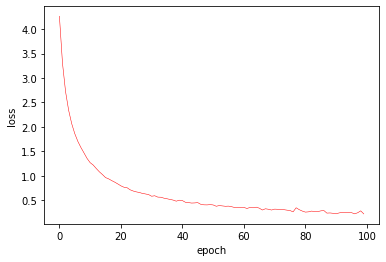

In [24]:
!pip install matplotlib
import matplotlib.pyplot as plt


plt.xlabel("epoch")
plt.ylabel("loss")
x = list(range(len(epoch_losses)))
# print(x)
plt.plot(x,epoch_losses,linewidth=0.5,c='red')
plt.show()

In [25]:
class Testdataset(Traindataset):
  def process(self):
    # 将数据处理为图列表和标签列表
    self.graphs, self.label = gpu_test_g, gpu_test_l

In [26]:
dataset = Testdataset()
dataloader = GraphDataLoader(
  dataset,
  batch_size=bt_size,
  drop_last=True,
  shuffle=True)

In [27]:
from sklearn.metrics import classification_report
# Test the model
model.eval()  # eval mode(batch norm uses moving mean/variance 
              #instead of mini-batch mean/variance)
with torch.no_grad():
  pred = []
  true = []
  for batched_graph, labels in dataloader:
      feats = batched_graph.ndata['attr']
      outputs = model(batched_graph, feats)
      _, predicted = torch.max(outputs.data, 1)
      pred.extend(predicted.cuda().data.cpu().numpy())
      true.extend(labels.cuda().data.cpu().numpy())
  
print(classification_report(true, pred, target_names=apps, digits=4))
#nhacvang 0.68, kaka 0.69, tunefm 0.76, tivi247 0.76

                          precision    recall  f1-score   support

                  diijam     0.9579    0.8585    0.9055       106
                  baomoi     0.9682    0.9870    0.9775       154
                 fptplay     1.0000    0.9391    0.9686       115
                   iQIYI     0.9946    0.9893    0.9920       187
                    bigo     0.9918    0.9757    0.9837       247
                 myradio     0.9328    0.9250    0.9289       120
                 spotify     0.9577    0.9668    0.9623       211
              nhaccuatui     0.9833    0.9866    0.9850       299
              soundcloud     0.9474    0.9851    0.9659       201
              sachnoiapp     0.8582    0.8333    0.8456       138
                 phim247     0.9417    0.9339    0.9378       121
                 popskid     0.9851    0.9778    0.9814       135
  truyenaudiosachnoiviet     0.8182    0.9153    0.8640        59
                   vieon     0.9643    0.9474    0.9558       114
         